In [5]:
# (1) LIc積固定時のIC毎の遅延ぱらつきシミュレーション
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from concurrent.futures import ThreadPoolExecutor
import threading, time

from circuit_sim import circuit_sim

# スレッドごとの排他制御（ファイル書き込み用）
# lock = threading.Lock()

lic = 74.4 * 2.4
bias_vol_v = 0.5 * 10**(-3)

def run_simulation(i):
    time.sleep(i)

    sim_con = circuit_sim("jtl_ush.cir")
    Ic = i * 10
    sim_con.new_make_jtl2(Ic, lic, bias_vol_v)
    sim_con.sim()
    netlist_file = f"jitter_ush/jitter_{i}.cir"
    sim_con.output_netlist(netlist_file)

    diff_file = f"jitter_ush/delays{i}.csv"
    open(diff_file, "w").close()
    sim_con.calc_jitter(
        ["P(B1|X1|X2|X2)", "P(B2|X1|X2|X2)"],
        ["P(B1|X2|X6|X7)", "P(B2|X2|X6|X7)"],
        # ["P(B1|X1|X1|X35)", "P(B2|X1|X1|X35)"],
        # ["P(B1|X2|X20|X35)", "P(B2|X2|X20|X35)"],
        40, diff_file, try_count=10000 #14h40m
    )

    data = pd.read_csv(diff_file)
    data[0] = data[0].apply(lambda x: 0 if abs(x) <= 1e-20 else x)
    data.to_csv(diff_file, index=False, header=False)

    # 出力ファイルへの同時書き込みを防止
    # with lock:
    #     with open("jitter.csv", "a") as f:
    #         f.write(f"{lic},{Ic},{mu},{std}\n")

if __name__ == "__main__":
    for i in [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]:
    # for i in range(1, 10 + 1):
        open(f"jitter_ush/delays{i}.csv", "w").close()

    # sim_con = circuit_sim("jtl_base.cir")
    # res = sim_con.get_switch_timing(["P(B1|X1|X2|X2)", "P(B2|X1|X2|X2)"])
    # print(res)
    # print(res.iloc[0,0])
    # print(res.iloc[1,0])

    max_workers = 12
    indices = [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]
    # max_workers = 10
    # indices = range(1, 10 + 1)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        executor.map(run_simulation, indices)


L_propagete_loop_pH_1: 42.768
L_propagete_loop_pH_1: 28.512
L_propagete_loop_pH_1: 21.384
L_propagete_loop_pH_1: 17.107
L_propagete_loop_pH_1: 14.256
L_propagete_loop_pH_1: 10.692
L_propagete_loop_pH_1: 8.554
L_propagete_loop_pH_1: 7.128
L_propagete_loop_pH_1: 6.11
L_propagete_loop_pH_1: 5.346
L_propagete_loop_pH_1: 4.752
L_propagete_loop_pH_1: 4.277


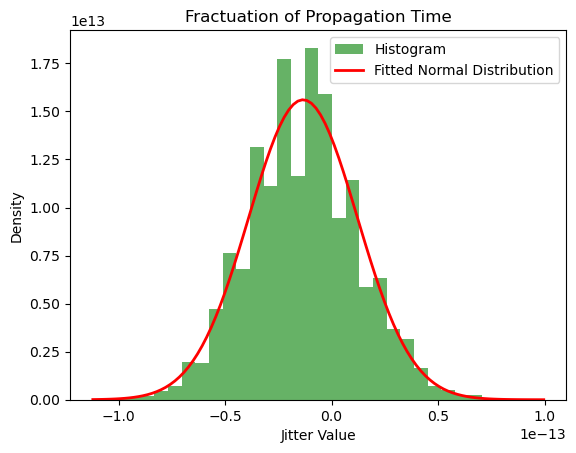

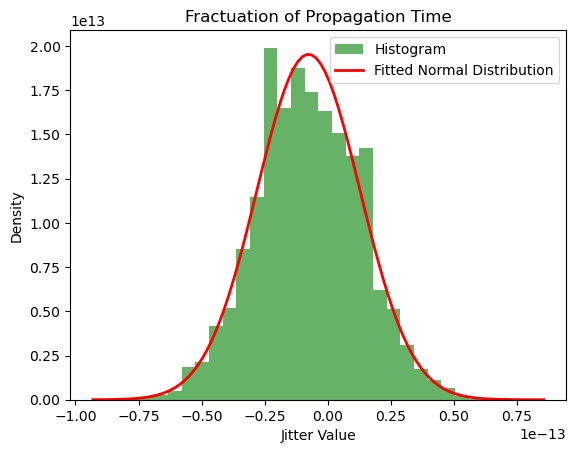

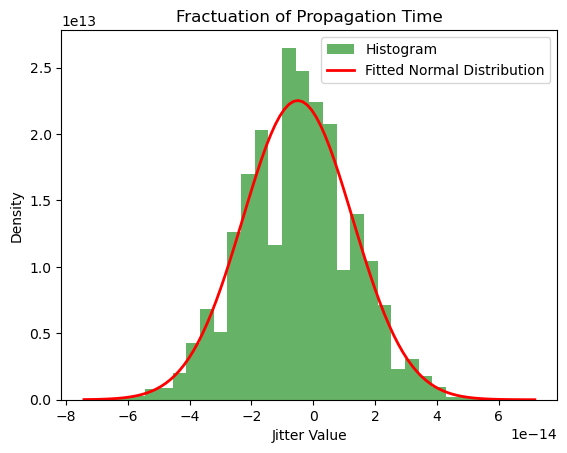

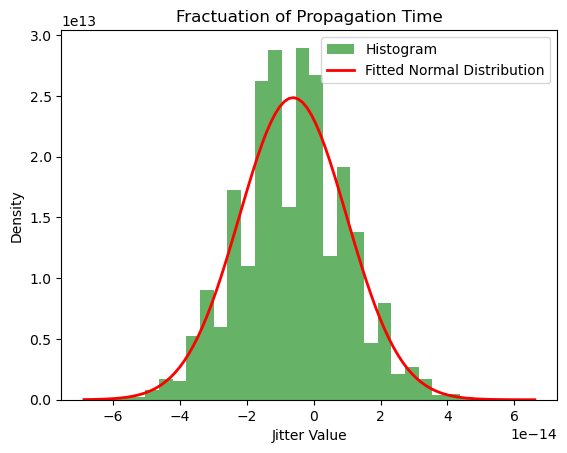

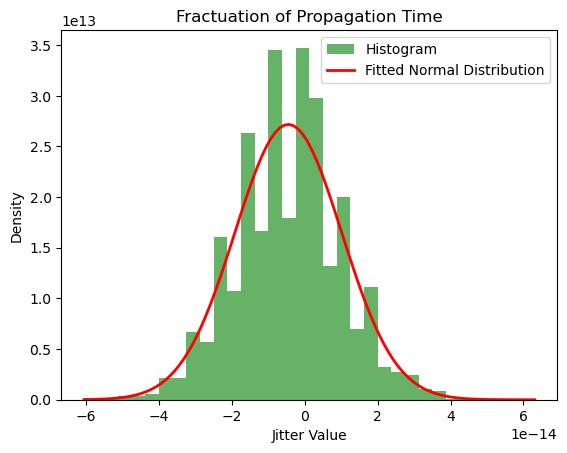

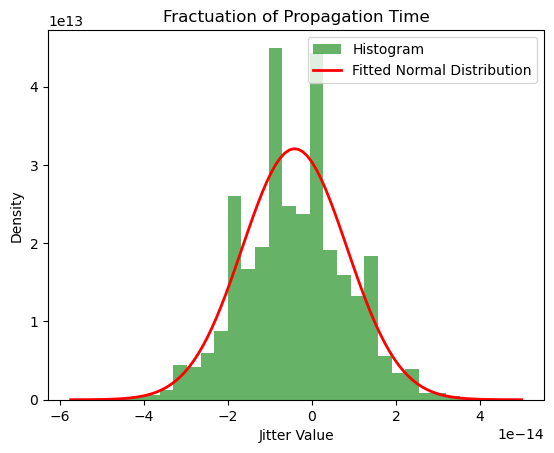

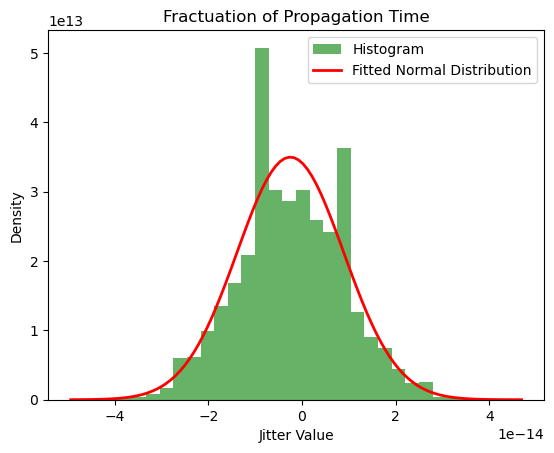

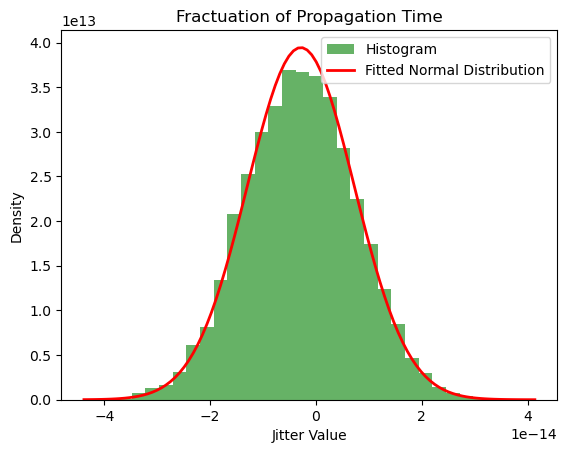

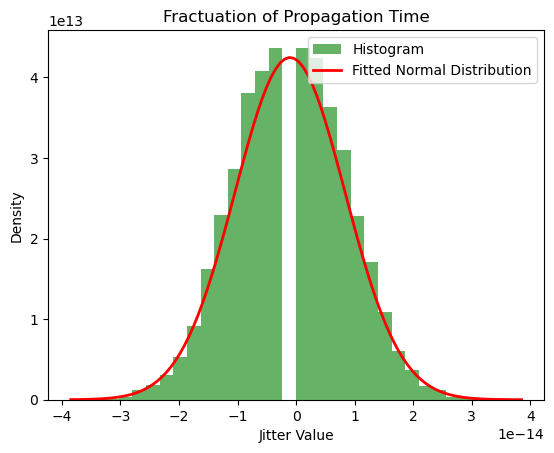

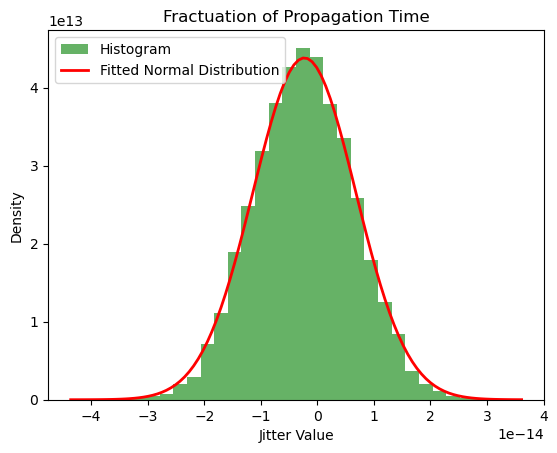

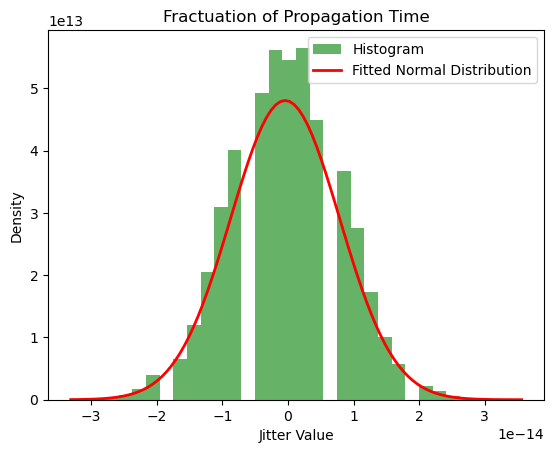

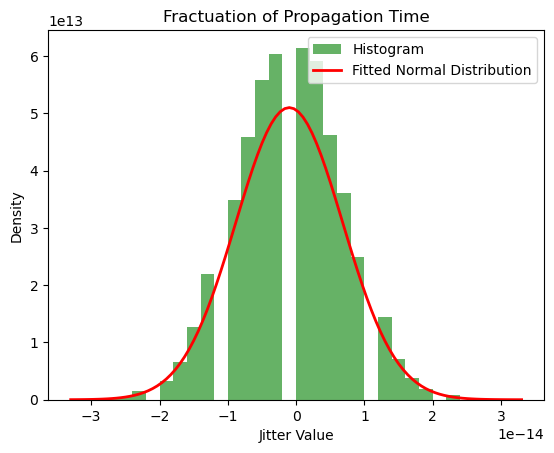

In [6]:
# (2) 臨界電流値毎の遅延ぱらつきヒストグラムの作成
plt.rcParams['font.family'] = ''
open("jitter_ush.csv", "w").close()

for i in [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]:
# for i in range(1, 10 + 1):
    Ic = i * 10
    diff_file = f"jitter_ush/delays{i}.csv"
    data = pd.read_csv(diff_file)
    mu, std = norm.fit(data)

    with open("jitter_ush.csv", "a") as f:
        f.write(f"{lic},{Ic},{mu},{std}\n")

    fig = plt.figure()
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label="Histogram")
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label="Fitted Normal Distribution")
    plt.xlabel("Jitter Value")
    plt.ylabel("Density")
    plt.title("Fractuation of Propagation Time")
    plt.legend()
    plt.savefig(f"jitter/jitter_{i}.png")
    plt.show()
    plt.close()

       lic     ic          mean        jitter
0   178.56   10.0 -1.340434e-14  2.556168e-14
1   178.56   15.0 -7.633513e-15  2.042456e-14
2   178.56   20.0 -5.020752e-15  1.771434e-14
3   178.56   25.0 -6.149615e-15  1.604246e-14
4   178.56   30.0 -4.543954e-15  1.467693e-14
5   178.56   40.0 -4.114911e-15  1.243401e-14
6   178.56   50.0 -2.489749e-15  1.139741e-14
7   178.56   60.0 -2.877538e-15  1.011479e-14
8   178.56   70.0 -1.047105e-15  9.393948e-15
9   178.56   80.0 -2.294729e-15  9.106895e-15
10  178.56   90.0 -4.315432e-16  8.304859e-15
11  178.56  100.0 -1.013101e-15  7.821355e-15


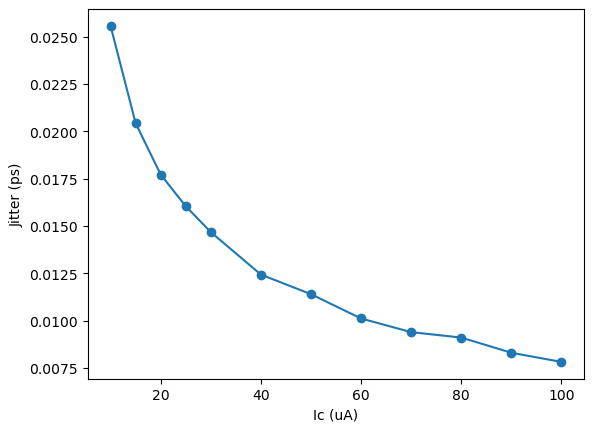

In [7]:
# (3) 臨界電流値毎のジッタのグラフの作成
file = "jitter_ush.csv"
df = pd.read_csv(file,names=["lic","ic","mean","jitter"])
df_192 = df[df["lic"]==74.4*2.4]
print(df_192)

x = df_192["ic"]
y = df_192["jitter"]
y = y*10**12

fig = plt.figure()
plt.plot(x, y, marker="o")
plt.xlabel('Ic (uA)')
plt.ylabel('Jitter (ps)')
plt.show()
plt.close()